In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [3]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_fine']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_fine'])
df = df[df['y_fine'] >= 100000]
df = df[df['y_fine'] <= 3000000]

In [4]:
X = df.drop('y_fine', axis=1)
y = df['y_fine']/100000

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [7]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [8]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_4)


dense_layer_4_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_4)
dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [9]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 100

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

9961


In [10]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_1_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(4, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)
conv_2_3 = tf.keras.layers.Conv2D(num_filters, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(reshape_3)

maxpool_0_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0_3)
maxpool_1_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 4 + 1, 1), strides=(1,1), padding='valid')(conv_1_3)
maxpool_2_3 = tf.keras.layers.MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [11]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])

dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_3)

model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

In [13]:
model.compile(loss='mse', optimizer='Adamax', metrics=['mse', 'mae', 'mape'])
print(model.summary())
#Adamax

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 128, 128)     1275008     input_4[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 529)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 662)]        0                                            
______________________________________________________________________________________________

In [14]:
history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=16, epochs=100, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

Train on 579 samples, validate on 65 samples
Epoch 1/100
579/579 [==============================] - 3s 5ms/sample - loss: 173.6871 - mse: 152.1678 - mae: 10.0154 - mape: 117.7121 - val_loss: 118.1632 - val_mse: 95.4920 - val_mae: 8.4924 - val_mape: 103.9293
Epoch 2/100
579/579 [==============================] - 0s 699us/sample - loss: 109.0007 - mse: 87.9238 - mae: 8.1700 - mape: 127.9445 - val_loss: 115.0912 - val_mse: 95.7110 - val_mae: 8.3728 - val_mape: 91.7261
Epoch 3/100
579/579 [==============================] - 0s 662us/sample - loss: 100.1789 - mse: 81.6317 - mae: 7.7986 - mape: 116.9640 - val_loss: 111.1610 - val_mse: 92.8216 - val_mae: 8.3478 - val_mape: 99.3922
Epoch 4/100
579/579 [==============================] - 0s 665us/sample - loss: 94.7144 - mse: 77.0441 - mae: 7.6508 - mape: 118.8965 - val_loss: 110.6988 - val_mse: 93.5475 - val_mae: 8.3123 - val_mape: 95.4707
Epoch 5/100
579/579 [==============================] - 0s 686us/sample - loss: 91.6618 - mse: 74.9189 - mae

Epoch 40/100
579/579 [==============================] - 0s 736us/sample - loss: 27.0582 - mse: 11.7347 - mae: 2.7580 - mape: 30.7796 - val_loss: 105.8604 - val_mse: 90.7163 - val_mae: 7.9573 - val_mape: 88.7661
Epoch 41/100
579/579 [==============================] - 0s 751us/sample - loss: 25.9838 - mse: 11.0242 - mae: 2.6114 - mape: 30.4477 - val_loss: 103.5932 - val_mse: 88.8238 - val_mae: 7.8962 - val_mape: 86.7246
Epoch 42/100
579/579 [==============================] - 0s 761us/sample - loss: 25.9847 - mse: 11.3276 - mae: 2.6651 - mape: 33.2610 - val_loss: 104.8671 - val_mse: 90.4357 - val_mae: 7.9175 - val_mape: 84.2674
Epoch 43/100
579/579 [==============================] - 0s 738us/sample - loss: 25.5373 - mse: 11.2200 - mae: 2.6711 - mape: 29.6436 - val_loss: 103.6997 - val_mse: 89.5899 - val_mae: 7.9419 - val_mape: 85.6952
Epoch 44/100
579/579 [==============================] - 0s 731us/sample - loss: 24.8352 - mse: 10.7818 - mae: 2.6065 - mape: 34.0320 - val_loss: 99.2773 - v

Epoch 79/100
579/579 [==============================] - 0s 767us/sample - loss: 19.2057 - mse: 9.4749 - mae: 2.4220 - mape: 28.3197 - val_loss: 103.3994 - val_mse: 93.5645 - val_mae: 8.1049 - val_mape: 101.2582
Epoch 80/100
579/579 [==============================] - 0s 729us/sample - loss: 19.9102 - mse: 10.1311 - mae: 2.5082 - mape: 27.7834 - val_loss: 97.2620 - val_mse: 87.4446 - val_mae: 7.8710 - val_mape: 90.5543
Epoch 81/100
579/579 [==============================] - 0s 728us/sample - loss: 18.5912 - mse: 8.7754 - mae: 2.3301 - mape: 27.2208 - val_loss: 101.7006 - val_mse: 91.9261 - val_mae: 7.8433 - val_mape: 81.9334
Epoch 82/100
579/579 [==============================] - 0s 746us/sample - loss: 19.3032 - mse: 9.5620 - mae: 2.4872 - mape: 29.2393 - val_loss: 97.4990 - val_mse: 87.7870 - val_mae: 7.9179 - val_mape: 87.2902
Epoch 83/100
579/579 [==============================] - 0s 716us/sample - loss: 18.9457 - mse: 9.2514 - mae: 2.3703 - mape: 27.4915 - val_loss: 97.8810 - val_ms

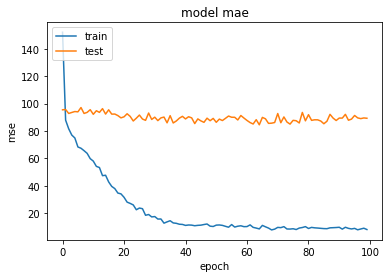

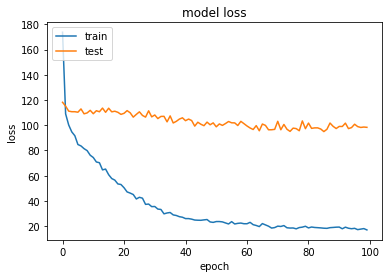

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [16]:
score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
#print("Test MAE: ", score[2])

72/72 [==============================] - 0s 2ms/sample - loss: 82.5419 - mse: 73.5406 - mae: 7.0344 - mape: 103.2579
[82.54187817043729, 73.54058, 7.0343585, 103.257866]
Test Score: 82.54187817043729
Test MSE: 73.54058


In [ ]:
# 